In [421]:
#python libraries
import os, re, sys, copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import FFCoSTA

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

### DATA CLEANING

In [215]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#, format="ISO8601")#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### FEATURE ENGINEERING ###

In [216]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [217]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [218]:
data = sensor_data.copy()
cols_to_drop = ['1MainBR_hum_temperature', '2BalconyEntrance_temperature', '2LRWindow_temperature',
                '2LivingRoomCenter_humidity_temperature', '2LivingRoom_humidifier_temperature'] #due to correlation
data = data.drop(cols_to_drop, axis=1)

data["0BTLivingRoom_temperature"] = (data["0BTCeiling_temperature"] + data["0BTFloor_temperature"])/2
data = data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

data["1Entrance_temperature"] = (data["1Entrance1_temperature"] + data["1StairBottom_temperature"])/2
data = data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

drop_hum_and_water_data = True
if drop_hum_and_water_data:
    data = data.drop(data.columns[data.columns.str.endswith('humidity')], axis=1)
    data = data.drop(data.columns[data.columns.str.endswith('water')], axis=1)

In [219]:
train_df_1 = data.loc[(data.index.month < 7) & (data.index.year == 2022)].copy()
train_df_2 = data.loc[((data.index.month > 8) & (data.index.year == 2022))|(data.index.year == 2023)].copy()
train_df_1_temp = train_df_1.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
train_df_2_temp = train_df_2.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
val_df = data.loc[(data.index.month == 8) & (data.index.year == 2022)].copy()
val_df_temp = val_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
test_df = data.loc[(data.index.month == 7) & (data.index.year == 2022)].copy()
test_df_temp = test_df.loc[:, data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

warmup_length = 48
train_warmup_temp_1 = [train_df_1_temp.values[i:i+warmup_length] for i in range(train_df_1_temp.values.shape[0]-(warmup_length))]
train_warmup_temp_2 = [train_df_2_temp.values[i:i+warmup_length] for i in range(train_df_2_temp.values.shape[0]-(warmup_length))]
train_warmup_outdoor_1 = [train_df_1["1OutdoorEntrance_temperature"].values[i:i+warmup_length] for i in range(train_df_1.values.shape[0]-(warmup_length))]
train_warmup_outdoor_2 = [train_df_2["1OutdoorEntrance_temperature"].values[i:i+warmup_length] for i in range(train_df_2.values.shape[0]-(warmup_length))]

train_df_1 = train_df_1[warmup_length:]
train_df_1["train_warmup_temp"] = train_warmup_temp_1
train_df_1["train_warmup_out"] = train_warmup_outdoor_1
train_df_2 = train_df_2[warmup_length:]
train_df_2["train_warmup_temp"] = train_warmup_temp_2
train_df_2["train_warmup_out"] = train_warmup_outdoor_2

train_labels_1 = train_df_1.loc[:, train_df_1.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1).shift(-1).dropna()
train_labels_2 = train_df_2.loc[:, train_df_2.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1).shift(-1).dropna()

train_labels = pd.concat([train_labels_1, train_labels_2])
train_df = pd.concat([train_df_1[:-1], train_df_2[:-1]])
train_temp = train_df.loc[:, train_df.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
train_temp_warmup = train_df.loc[:, "train_warmup_temp"]
train_outdoor = train_df.loc[:, ["1OutdoorEntrance_temperature"]]
train_outdoor_warmup = train_df.loc[:, "train_warmup_out"]
train_door = train_df.loc[:, train_df.columns.str.endswith('door')].sort_index(axis=1)
train_timing = train_df.iloc[:, -8:-2]

val_temp_warmup = [val_df_temp.values[i:i+warmup_length] for i in range(val_df_temp.values.shape[0]-(warmup_length))]
val_oudoor_warmup = [val_df["1OutdoorEntrance_temperature"].values[i:i+warmup_length] for i in range(val_df.values.shape[0]-(warmup_length))]
val_df = val_df[warmup_length:]
val_df["val_warmup_temp"] = val_temp_warmup
val_df["val_warmup_out"] = val_oudoor_warmup
val_labels = val_df.loc[:, val_df.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1).shift(-1).dropna()
val_df = val_df[:-1]
val_temp = val_df.loc[:, val_df.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
val_temp_warmup = val_df.loc[:, "val_warmup_temp"]
val_outdoor = val_df.loc[:, ["1OutdoorEntrance_temperature"]]
val_outdoor_warmup = val_df.loc[:, "val_warmup_out"]
val_door = val_df.loc[:, val_df.columns.str.endswith('door')].sort_index(axis=1)
val_timing = val_df.iloc[:, -8:-2]

test_temp_warmup = [test_df_temp.values[i:i+warmup_length] for i in range(test_df_temp.values.shape[0]-(warmup_length))]
test_oudoor_warmup = [test_df["1OutdoorEntrance_temperature"].values[i:i+warmup_length] for i in range(test_df.values.shape[0]-(warmup_length))]
test_df = test_df[warmup_length:]
test_df["test_warmup_temp"] = test_temp_warmup
test_df["test_warmup_out"] = test_oudoor_warmup
test_labels = test_df.loc[:, test_df.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1).shift(-1).dropna()
test_df = test_df[:-1]
test_temp = test_df.loc[:, test_df.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)
test_temp_warmup = test_df.loc[:, "test_warmup_temp"]
test_outdoor = test_df.loc[:, ["1OutdoorEntrance_temperature"]]
test_outdoor_warmup = test_df.loc[:, "test_warmup_out"]
test_door = test_df.loc[:, test_df.columns.str.endswith('door')].sort_index(axis=1)
test_timing = test_df.iloc[:, -8:-2]

print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of train_labels = {train_labels.shape}, Shape of val_labels = {val_labels.shape}, Shape of test_labels = {test_labels.shape}")
train_df.describe()

Shape of train_df = (33116, 24), Shape of val_df = (2927, 24), Shape of test_df = (2927, 24)
Shape of train_labels = (33116, 10), Shape of val_labels = (2927, 10), Shape of test_labels = (2927, 10)


,0BGuest_door,0BRoom_temperature,0BTLivingRoom_temperature,0B_door,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1Main_door,1OutdoorEntrance_temperature,2Cooking_temperature,...,2LivingRoomCenter_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,cos_daily,cos_weekly,cos_yearly,sin_daily,sin_weekly,sin_yearly
count,33116.000000,33116.000000,33116.000000,33116.000000,33116.000000,33116.000000,33116.000000,33116.00000,33116.000000,33116.000000,...,33116.000000,33116.000000,33116.000000,33116.000000,3.311600e+04,33116.000000,33116.000000,33116.000000,33116.000000,33116.000000
mean,0.784908,19.970393,20.085602,0.160315,21.890827,18.389013,17.731723,0.99547,5.663869,21.445304,...,21.178311,19.934776,0.398901,21.393341,-9.300555e-04,-0.000285,0.254899,-0.001216,-0.003092,0.143198
std,0.410893,2.870614,2.550297,0.366904,1.571408,3.108373,3.003069,0.06715,6.296199,2.951409,...,2.549807,3.322562,0.489680,2.604404,7.071315e-01,0.706624,0.653704,0.707102,0.707603,0.698011
min,0.000000,10.250000,14.650000,0.000000,14.658333,5.700000,3.200000,0.00000,-14.650000,10.000000,...,10.416667,10.525000,0.000000,10.950000,-1.000000e+00,-0.900969,-0.999611,-1.000000,-0.974928,-0.999999
25%,1.000000,18.550000,18.162500,0.000000,21.350000,17.200000,16.400000,1.00000,1.500000,19.700000,...,19.783333,18.016667,0.000000,20.000000,-7.071068e-01,-0.900969,-0.287174,-0.707107,-0.781831,-0.569805
50%,1.000000,19.900000,20.039583,0.000000,22.200000,18.850000,18.100000,1.00000,4.950000,21.250000,...,21.066667,19.733333,0.000000,21.233333,-1.836970e-16,-0.222521,0.433564,0.000000,0.000000,0.337308
75%,1.000000,21.800000,21.958333,0.000000,22.887500,20.150000,19.450000,1.00000,9.800000,23.300000,...,22.800000,21.916667,1.000000,22.775000,7.071068e-01,0.623490,0.859013,0.707107,0.781831,0.746600
max,1.000000,27.400000,28.725000,1.000000,26.125000,28.200000,27.350000,1.00000,32.500000,37.650000,...,30.416667,32.150000,1.000000,29.800000,1.000000e+00,1.000000,0.999991,1.000000,0.974928,0.999986


In [265]:
class HAMDataset(Dataset):
    def __init__(self, temp, label, warmup_temp, warmup_outdoor, outdoor, door, timing):
        self.temp = torch.tensor(temp, requires_grad=True, dtype=torch.float32)
        self.label = torch.tensor(label, dtype=torch.float32)
        self.warmup_temp = torch.tensor(list(warmup_temp), dtype=torch.float32)
        self.warmup_outdoor = torch.tensor(list(warmup_outdoor), dtype=torch.float32)
        self.outdoor = torch.tensor(outdoor, dtype=torch.float32)
        self.door = torch.tensor(door, dtype=torch.float32)
        self.timing = torch.tensor(timing, dtype=torch.float32)

    def __len__(self):
        return len(self.temp)

    def __getitem__(self, idx):
        return self.temp[idx], self.label[idx], self.warmup_temp[idx], self.warmup_outdoor[idx], self.outdoor[idx], self.door[idx], self.timing[idx]

In [406]:
train_data = HAMDataset(train_temp.values, train_labels.values, train_temp_warmup.values, train_outdoor_warmup.values, train_outdoor.values, train_door.values, train_timing.values)
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)

val_data = HAMDataset(val_temp.values, val_labels.values, val_temp_warmup.values, val_outdoor_warmup.values, val_outdoor.values, val_door.values, val_timing.values)
val_loader = DataLoader(val_data, batch_size=100, shuffle=False)

test_data = HAMDataset(test_temp.values, test_labels.values, test_temp_warmup.values, test_outdoor_warmup.values, test_outdoor.values, test_door.values, test_timing.values)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

### DEFINE PBM MODEL

In [312]:
import asset
import PBM
import importlib
importlib.reload(PBM)
importlib.reload(asset)

gfBedroom = asset.Zone("gfBedroom",       [0.34146, 1.36584, 1.36584, 0.34146],           [41652.8784, 402850.8])
gfLivingroom = asset.Zone("gfLivingroom", [0.598068, 2.392272, 2.392272, 0.598068],       [157355.3184, 747837.36])
stairs = asset.Zone("stairs",             [0.4067498, 1.6269992, 1.6269992, 0.4067498],   [69035.7892, 647290.4264])
gfBath = asset.Zone("gfBath",             [0.2705976, 1.0823904, 1.0823904, 0.2705976],   [44159.7646, 434698.992])
gfStorage = asset.Zone("gfStorage",       [0.2901384, 1.1605536, 1.1605536, 0.2901384],   [49173.537, 466090.128])
f1Guestroom = asset.Zone("f1Guestroom",   [0.366948, 1.467792, 1.467792, 0.366948],       [49944.8866, 443795.76])
f1Mainroom = asset.Zone("f1Mainroom",     [0.421254, 1.685016, 1.685016, 0.421254],       [66721.7404, 525431.88])
f1Sleep3 = asset.Zone("f1Sleep3",         [0.370791, 1.483164, 1.483164, 0.370791],       [49559.2118, 486390.42])
f1Bath = asset.Zone("f1Bath",             [0.172752, 0.691008, 0.691008, 0.172752],       [37796.1304, 277515.84])
f1Storage = asset.Zone("f1Storage",       [0.423831, 1.695324, 1.695324, 0.423831],       [26033.049, 673890.636])
f1Entrance = asset.Zone("f1Entrance",     [0.123192, 0.492768, 0.492768, 0.123192],       [88512.3666, 197900.64])
f2Livingroom = asset.Zone("f2Livingroom", [2.6243349, 10.4973396, 10.4973396, 2.6243349], [345178.946, 3373189.904])
f2Office = asset.Zone("f2Office",         [0.3805635, 1.522254, 1.522254, 0.3805635],     [42424.228, 462828.5916])
zones = [gfBedroom, gfLivingroom, stairs, gfBath, gfStorage, f1Guestroom, f1Mainroom, f1Sleep3, f1Bath, f1Storage, f1Entrance, f2Livingroom, f2Office]

connections =  [{"rooms": ["gfBedroom", "gfLivingroom"],    "R": 10.35216, "C": 179373.6}, 
                {"rooms": ["gfBedroom", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfBedroom", "f1Guestroom"],     "R": 2.016, "C": 207012.6},
                {"rooms": ["gfLivingroom", "gfBath"],       "R": 9.785256, "C": 169550.76},
                {"rooms": ["gfLivingroom", "stairs"],       "R": 38.10888, "C": 0},
                {"rooms": ["gfLivingroom", "f1Entrance"],   "R": 2.7216, "C": 279467.01},
                {"rooms": ["gfLivingroom", "f1Mainroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["gfBath", "gfStorage"],          "R": 5.91552, "C": 102499.2},
                {"rooms": ["gfBath", "f1Sleep3"],           "R": 1.12896, "C": 115927.056},
                {"rooms": ["gfStorage", "stairs"],          "R": 4.43664, "C": 76874.4},
                {"rooms": ["gfStorage", "f1Bath"],          "R": 1.82784, "C": 187691.424},
                {"rooms": ["f1Guestroom", "f1Mainroom"],    "R": 7.3944, "C": 128124},
                {"rooms": ["f1Guestroom", "f1Entrance"],    "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "stairs"],        "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Guestroom", "f2Livingroom"],  "R": 2.4192, "C": 248415.12},
                {"rooms": ["f1Mainroom", "f1Sleep3"],       "R": 5.17608, "C": 89686.8},
                {"rooms": ["f1Mainroom", "f1Entrance"],     "R": 6.65496, "C": 115311.6},
                {"rooms": ["f1Mainroom", "f2Livingroom"],   "R": 3.2256, "C": 331220.16},
                {"rooms": ["f1Sleep3", "f1Entrance"],       "R": 12.57048, "C": 217810.8},
                {"rooms": ["f1Sleep3", "f2Livingroom"],     "R": 2.39904, "C": 246344.994},
                {"rooms": ["f1Entrance", "f1Bath"],         "R": 3.94368, "C": 68332.8},
                {"rooms": ["f1Entrance", "stairs"],         "R": 38.10888, "C": 0},
                {"rooms": ["f1Entrance", "f2Livingroom"],   "R": 4.28064, "C": 439556.754},
                {"rooms": ["f1Bath", "f1Storage"],          "R": 0.72216, "C": 116010.72},
                {"rooms": ["f1Bath", "stairs"],             "R": 4.43664, "C": 76874.4},
                {"rooms": ["f1Bath", "f2Office"],           "R": 1.82784, "C": 187691.424},
                {"rooms": ["f2Livingroom", "f2Office"],     "R": 12.089844, "C": 209482.74},
                {"rooms": ["f2Livingroom", "stairs"],       "R": 43.131254, "C": 0},
                {"rooms": ["f2Office", "stairs"],           "R": 4.729335, "C": 81945.975}]

house = asset.Asset(zones, connections)

thermoPBM = PBM.thermoPBM(house)


In [447]:
pbm_out = torch.zeros((test_outdoor.shape[0],  13))
pbm_out_wall = torch.zeros((test_outdoor.shape[0], 13))

delta_t = 60
N = 15

for i, (temp, label, warmup_temp, warmup_outdoor, outdoor, door, timing) in enumerate(test_loader):
    if i == 0:
        T_room = FFCoSTA.pbm_temp_from_sensor(temp)
        T_wall = torch.zeros_like(T_room)
    
    for _ in range(N):
        T_room, T_wall = thermoPBM(T_room, T_wall, outdoor, delta_t)
    
    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall


MAE: 1.3888075352529636


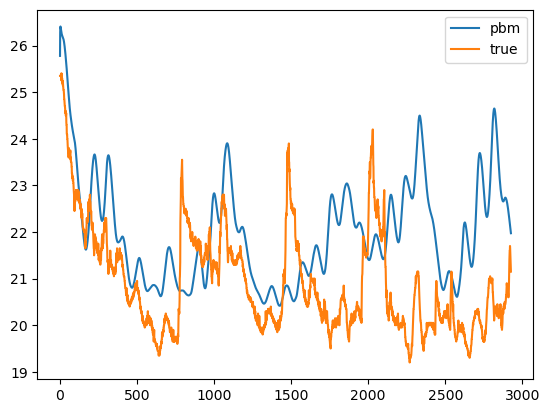

In [449]:
plt.plot(pbm_out.detach()[:, 0], label="pbm")
# plt.plot(pbm_out_wall.detach()[:plot_n, 0], label="pbm wall")
plt.plot(test_temp.iloc[:, 0].values, label="true")
plt.legend()
print(f'MAE: {np.mean(np.abs(test_temp.iloc[:, 0] - pbm_out.detach().numpy()[:, 0]))}')

### CoSTA

In [315]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [420]:
import FFNNModel
importlib.reload(FFNNModel)
importlib.reload(PBM)

house = asset.Asset(zones, connections)
thermoPBM = PBM.thermoPBM(house)

In [419]:
importlib.reload(FFCoSTA)

layers = [38, 128, 128, 128, 26]
NNModel = FFNNModel.Net(layers)

model = FFCoSTA.FFCoSTA(thermoPBM, NNModel)

epochs = 1000
lr = 0.01
l2_reg = 0.001

model.train(train_loader, val_loader, epochs, lr, l2_reg)

Epoch: 1, Epoch Train MSE: 2.4355230226236233
Epoch: 1, Val MAE: 24.918521881103516
Epoch: 2, Epoch Train MSE: 1.8615269205149483
Epoch: 2, Val MAE: 24.4689998626709
Epoch: 3, Epoch Train MSE: 1.5188174633418812
Epoch: 3, Val MAE: 20.986154556274414
Epoch: 4, Epoch Train MSE: 1.3981462331379162
Epoch: 4, Val MAE: 21.196619033813477
Epoch: 5, Epoch Train MSE: 1.3272318243980408
Epoch: 5, Val MAE: 19.92875099182129
Epoch: 6, Epoch Train MSE: 1.1939205667551827
Epoch: 6, Val MAE: 21.05715560913086
Epoch: 7, Epoch Train MSE: 1.1546841789694393
Epoch: 7, Val MAE: 18.326309204101562


KeyboardInterrupt: 

In [ ]:
for i, (temp, label, warmup_temp, warmup_outdoor, outdoor, door, timing) in list(enumerate(train_loader))[:1]:

    T_room_warmup = FFCoSTA.pbm_temp_from_sensor(warmup_temp[:, 0, :])
    T_wall_warmup = torch.zeros_like(T_room_warmup)
    
    batch_size = temp.shape[0]
    n_rooms = T_room_warmup.shape[0]
    for n in range(warmup_temp.shape[1]):
        for _ in range(N):
            T_room_warmup, T_wall_warmup = thermoPBM(T_room_warmup, T_wall_warmup, warmup_outdoor[:, n].unsqueeze(1), delta_t)


    T_room, T_wall = model(T_room, T_wall, outdoor, door, timing, 15, 60)

In [ ]:
save_model = False
if save_model:
    torch.save(model.state_dict(), 'models/CoSTA.pt')

In [414]:
sim_n = 1000

pbm_out = torch.zeros((sim_n, 13))
pbm_out_wall = torch.zeros((sim_n, 13))

delta_t = 60
N = 15

for i, (temp, label, warmup_temp, warmup_outdoor, outdoor, door, timing) in enumerate(list(test_loader)[:sim_n]):
    if i == 0:
        T_room_warmup = FFCoSTA.pbm_temp_from_sensor(warmup_temp[:, 0, :])
        T_wall_warmup = torch.zeros_like(T_room_warmup)
        
        for n in range(warmup_temp.shape[1]):
            for _ in range(N):
                T_room_warmup, T_wall_warmup = thermoPBM(T_room_warmup, T_wall_warmup, warmup_outdoor[:, n].unsqueeze(1), delta_t)


        T_room = FFCoSTA.pbm_temp_from_sensor(temp)
        T_wall = T_wall_warmup

    T_room, T_wall = model(T_room, T_wall, outdoor, door, timing, N, delta_t)

    pbm_out[i] = T_room
    pbm_out_wall[i] = T_wall

MAE: 0.637195205688478


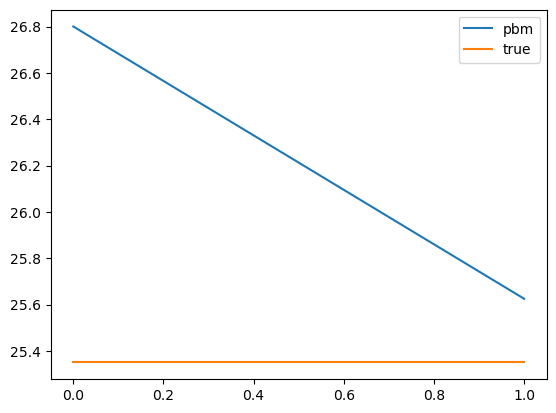

In [416]:
room = 0
sim_n=2
plt.plot(pbm_out.detach()[:sim_n, room]+1.5, label="pbm")
# plt.plot(pbm_out_wall.detach()[:sim_n, room], label="pbm wall")
plt.plot(test_temp.iloc[:sim_n, room].values, label="true")
plt.legend()
print(f'MAE: {np.mean(np.abs(test_temp.iloc[:sim_n, 0] - pbm_out.detach().numpy()[:sim_n, 0]))}')